# Training Model
___

This notebook demonstrates the complete workflow for training and evaluating a multiclass classification model using Pytorch. The steps include:

* to be included

## Load libraries

In [1]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

# Import custom utilities for architecture, data reading, figures, and metrics
import sys
sys.path.append('../')
from utils.architecture import Architecture
from utils.figures import *
from utils.images import visualize_images
from utils.metrics import get_metrics

# Data Preparation

Actual dataset from Mendeley Data:
> Amin, Md Al; Mahmud, Md Iqbal; Rahman, Asadullah Bin; Parvin, Mst Aktarina; Mamun, Md Abdulla Al (2024), “Guava Fruit Disease Dataset”, Mendeley Data, V1, doi: 10.17632/bkdkc4n835.1

## ImageFolder

In [2]:
# Compose a sequence of preprocessing transforms
# 1) Resize images
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    Resize(128),                        # Resize each image to 128×128
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'train' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root='../data/train',  # Path to the training data directory
    transform=temp_transform          # Apply the preprocessing pipeline to every image
)

In [3]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 128, 128]), 0)

In [4]:
temp_dataset[0][0]

Image([[[0.6745, 0.6784, 0.6863,  ..., 0.7412, 0.7412, 0.7451],
        [0.6784, 0.6745, 0.6706,  ..., 0.7412, 0.7451, 0.7451],
        [0.7059, 0.7020, 0.6980,  ..., 0.7412, 0.7451, 0.7412],
        ...,
        [0.6824, 0.6824, 0.6824,  ..., 0.4706, 0.4863, 0.4784],
        [0.6824, 0.6824, 0.6824,  ..., 0.4824, 0.4902, 0.4902],
        [0.6824, 0.6824, 0.6784,  ..., 0.4902, 0.4902, 0.4902]],

       [[0.6902, 0.6941, 0.7020,  ..., 0.7608, 0.7608, 0.7569],
        [0.6941, 0.6902, 0.6863,  ..., 0.7608, 0.7608, 0.7569],
        [0.7216, 0.7176, 0.7137,  ..., 0.7608, 0.7569, 0.7569],
        ...,
        [0.6667, 0.6667, 0.6667,  ..., 0.4784, 0.4941, 0.4863],
        [0.6667, 0.6667, 0.6667,  ..., 0.4902, 0.4941, 0.4941],
        [0.6667, 0.6667, 0.6706,  ..., 0.4941, 0.4941, 0.4941]],

       [[0.7137, 0.7216, 0.7255,  ..., 0.7725, 0.7765, 0.7843],
        [0.7216, 0.7176, 0.7137,  ..., 0.7725, 0.7804, 0.7843],
        [0.7451, 0.7412, 0.7373,  ..., 0.7725, 0.7804, 0.7843],
        ..

In [5]:
len(temp_dataset)

2647

In [6]:
temp_dataset[len(temp_dataset)-1][0].shape

torch.Size([3, 128, 128])

In [7]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {temp_dataset.classes}")

Dataset size: 2647 images
Number of classes: 3
Class names: ['Anthracnose', 'fruit_fly', 'healthy_guava']


ANTHRACNOSE


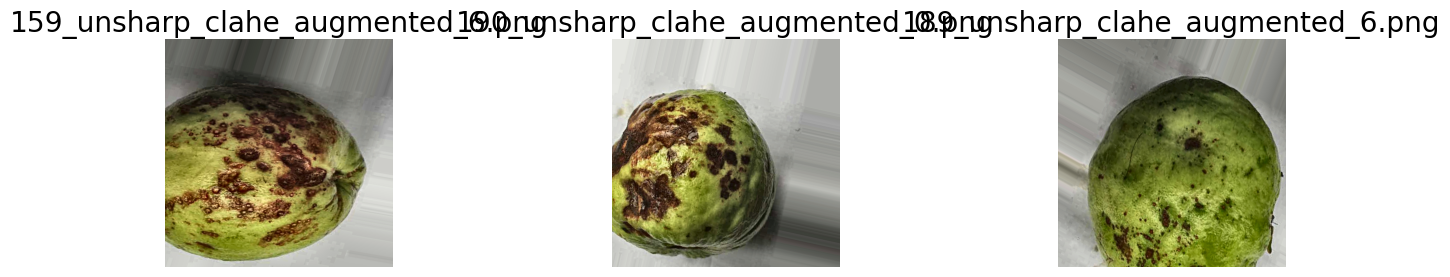

FRUIT_FLY


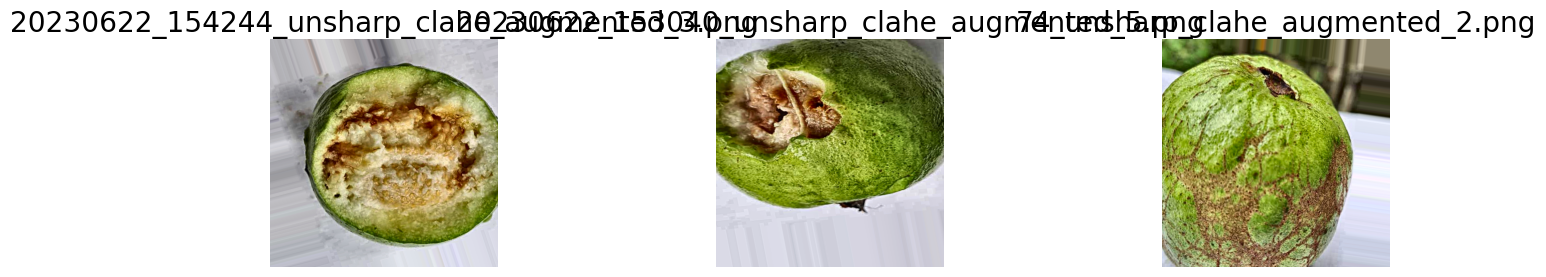

HEALTHY_GUAVA


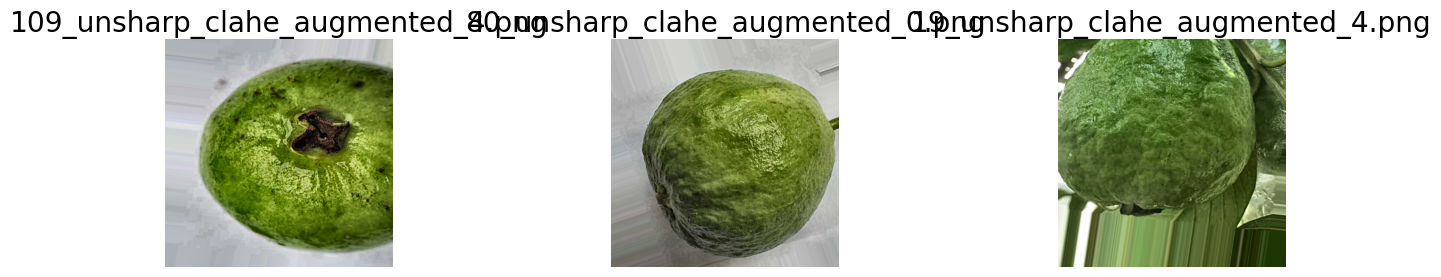

In [8]:
# Iterating through each class to plot its images
for label in temp_dataset.classes:
    
    # Specify the path containing the images to visualize
    path_to_visualize = f"../data/train/{label}"

    # Visualize 3 random images
    print(label.upper())
    visualize_images(path_to_visualize, num_images=3)

## Standardization

In [9]:
temp_loader = DataLoader(temp_dataset, batch_size=128)

In [10]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[128.0000, 128.0000, 128.0000],
        [ 68.3384,  68.9270,  51.2995],
        [ 22.8032,  23.2555,  33.8587]])

In [11]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[2647.0000, 2647.0000, 2647.0000],
        [1440.6030, 1478.2246, 1001.1700],
        [ 481.2236,  495.6259,  674.8077]])

In [12]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.5442), tensor(0.5585), tensor(0.3782)], std=[tensor(0.1818), tensor(0.1872), tensor(0.2549)], inplace=False)

> Remember that PyTorch converts the pixel values into the [0, 1] range. The average mean value of a pixel for the red (first) channel is 0.8502, while its average standard deviation is 0.2089.

>> **IMPORTANT**: Always use the training set to compute statistics
for standardization! This avoid data leakage!!!

## The Real Datasets

In [13]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize(128),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'rps' contains subfolders per class for training
# - 'rps-test-set' likewise for validation
train_data = ImageFolder(root='../data/train', transform=composer)
val_data   = ImageFolder(root='../data/val', transform=composer)
test_data   = ImageFolder(root='../data/test', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=128)  # no shuffle for validation
test_loader   = DataLoader(val_data,   batch_size=128)  # no shuffle for test

In [14]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Anthracnose', 'fruit_fly', 'healthy_guava']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

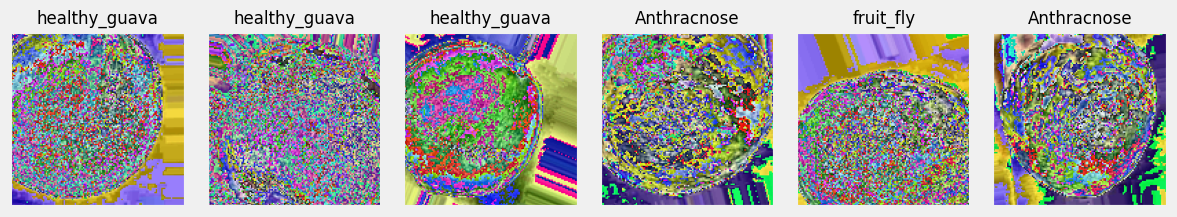

In [15]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

There is nothing wrong with the colors, it is just the effect of the standardization
of the pixel values.

# Model configuration

Let’s leave the Sequential model aside for now and build a model class again. This
time, our constructor method will take two arguments: ``n_filters`` and ``p``.

We’ll use
``n_filters`` as the number of output channels for both convolutional blocks of our
model (yes, there are two now!). And, as you can see from the code below, we’ll use
``p`` as the probability of **dropout**.

In [24]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        # self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        # self.fc2 = nn.Linear(50, 3)
        self.fc1 = nn.Linear(27, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        
        if self.p > 0:
            x = self.drop(x)
        x = self.fc3(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

The configuration part is short and straightforward:
- We create a model,
-  a loss function,
- and an optimizer.

The model will be an instance of our CNN2 class with five filters and a dropout
probability of 30%.

Our dataset has three classes, so we’re using
``nn.CrossEntropyLoss()`` (which will take the three logits produced by our model).

In [25]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=3, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

> Adaptive moment estimation (Adam) uses adaptive learning
rates, computing a learning rate for each parameter. Yes, you
read it right: Each parameter has a learning rate to call its own!


> If you dig into the state_dict() of an Adam optimizer, you’ll find
tensors shaped like the parameters of every layer in your model
that Adam will use to compute the corresponding learning rates.
True story!

In [26]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'decoupled_weight_decay': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}]}

## Model Training

In [66]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(20)

In [67]:
arch_cnn2.count_parameters()

4223

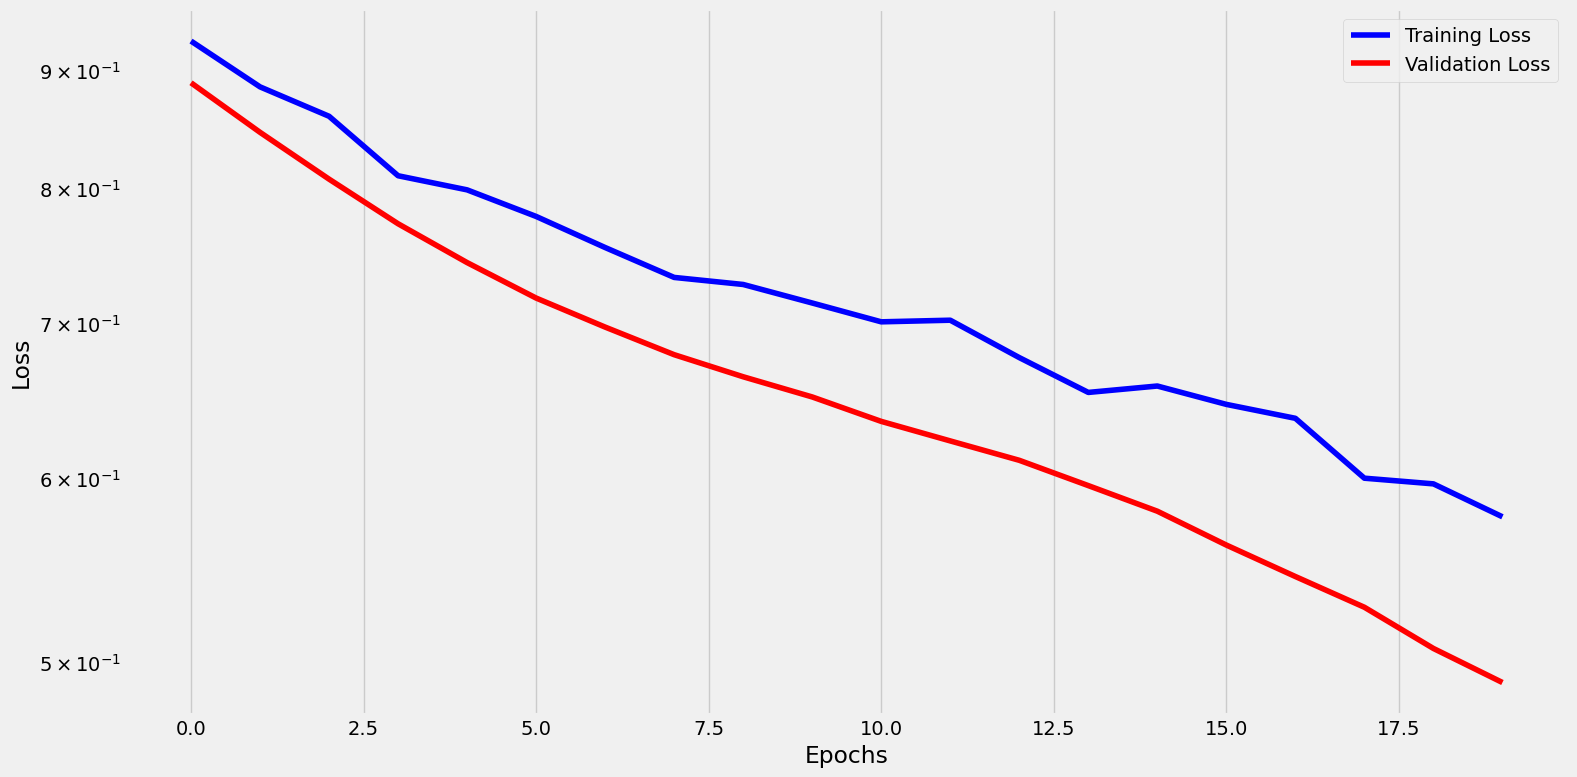

In [68]:
fig = arch_cnn2.plot_losses()

### Accuracy

In [69]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[261, 308],
        [189, 262],
        [165, 185]])

In [70]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([615, 755])

In [71]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.8145695364238411

### Confusion matrix

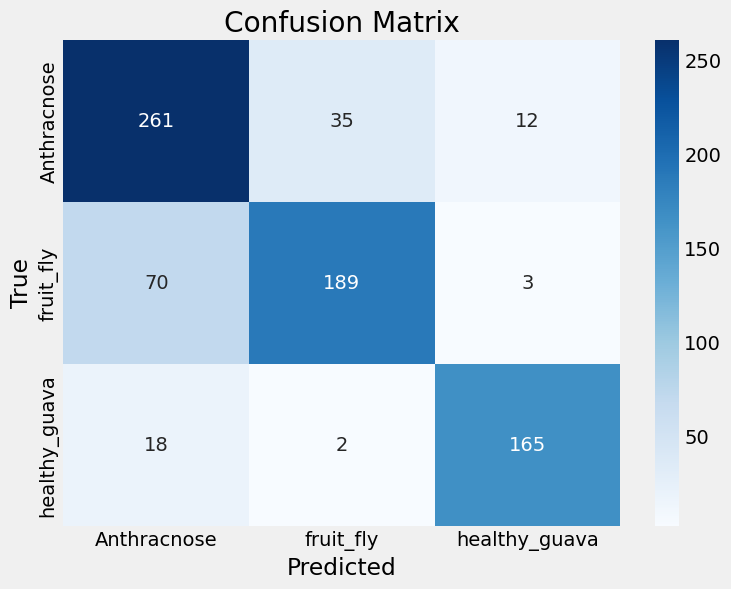

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_loader:
    logits = arch_cnn2.predict(images)
    preds = np.argmax(logits, axis=1)
    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=temp_dataset.classes, yticklabels=temp_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Saving model

In [73]:
from datetime import datetime

arch_cnn2.save_checkpoint(f'../model/model_checkpoint_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')

## Making predictions

In [81]:
# Predict the class of the image
images_batch, labels_batch = next(iter(test_loader))
logits = arch_cnn2.predict(images_batch)

predicted = np.argmax(logits, 1)

predicted_class = temp_dataset.classes[predicted[0]]

# Print the predicted class
print(f"Predicted class: {predicted_class}")

Predicted class: fruit_fly


In [82]:
temp_dataset.classes[labels_batch[0]]

'Anthracnose'

### Visualizing Filters

In [83]:
model_cnn2.conv1.weight.shape

torch.Size([3, 3, 3, 3])

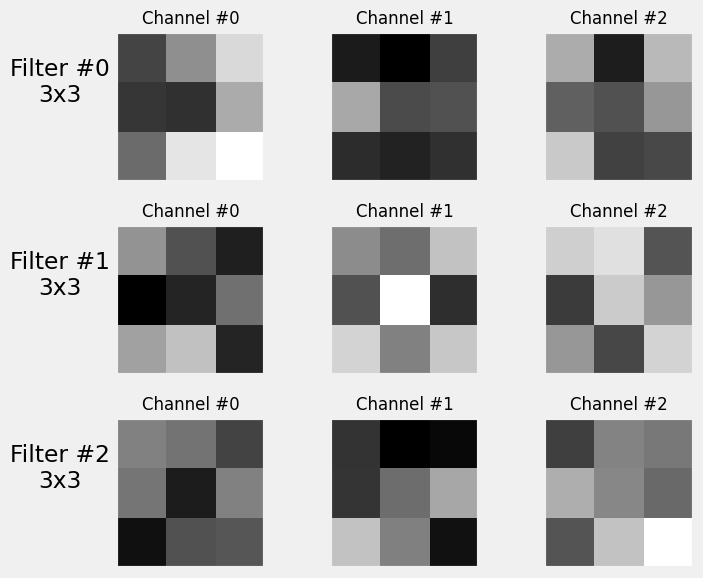

In [84]:
fig = arch_cnn2.visualize_filters('conv1')

In [85]:
model_cnn2.conv2.weight.shape

torch.Size([3, 3, 3, 3])

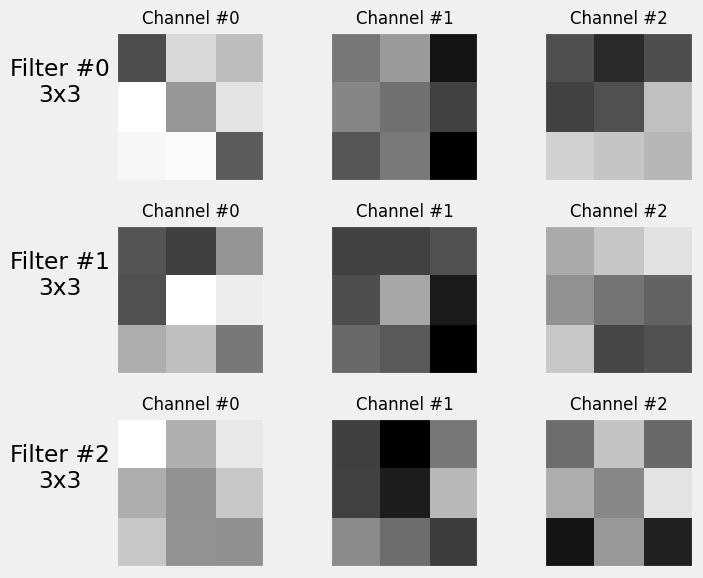

In [86]:
fig = arch_cnn2.visualize_filters('conv2')